# Исследование оттока посетителей фитнес-центра

Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Распространённая проблема для фитнеса — отток клиентов. Можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал.

Чтобы бороться с оттоком, отдел по работе с клиентами перевёл в электронный вид множество клиентских анкет. Задача — провести анализ и подготовить план действий по удержанию клиентов.

В частности, требуется:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами.

# Часть 1 - Загрузка и исследовательский анализ данных

Для начала загрузим необходимые библиотеки и файлы с данными.

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import warnings

In [2]:
# считываем csv-файл с данными
data = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
# для удобства убираем ограничения на число отображаемых колонок и скрываем дополнительные уведомления
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [4]:
# выводим сводку основной информации
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


В таблице нет пропусков и типы данных выглядят логично. Для единообразия отображения данных можно скорректировать названия двух колонок.

In [5]:
# корректируем названия колонок
data = data.rename(columns = {'gender': 'Gender', 'Near_Location': 'Near_location'})

Изучим описательную статистику по отдельным признакам. 

In [6]:
# выводим описательную статистику
data.describe()

,Gender,Near_location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


В целом данные выглядят реалистично - доли мужчин и женщин почти равны, средний возраст посетителей около 30 лет и редко "переваливает" за 40, обычно люди посещают зал 2-3 дня в неделю, в крайних случаях - до 6 дней.

Теперь посмотрим на средние значения признаков в разбивке на ушедших и оставшихся клиентов.

In [7]:
# считаем средние значения в группировке по факту оттока клиентов
data.groupby('Churn').agg('mean')

,Gender,Near_location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Мы видим, что наибольшие отличия между группами (примерно в 2 раза или более) наблюдаются по таким признакам, как запись по акции, посещение групповых занятий, длительность абонемента и срок до его окончания, общий период посещений, а также частота посещений за последний месяц.    

Чтобы внимательнее ознакомиться с подобными различиями построим гистограммы по количественным признакам для ушедших и оставшихся клиентов фитнес-центра.

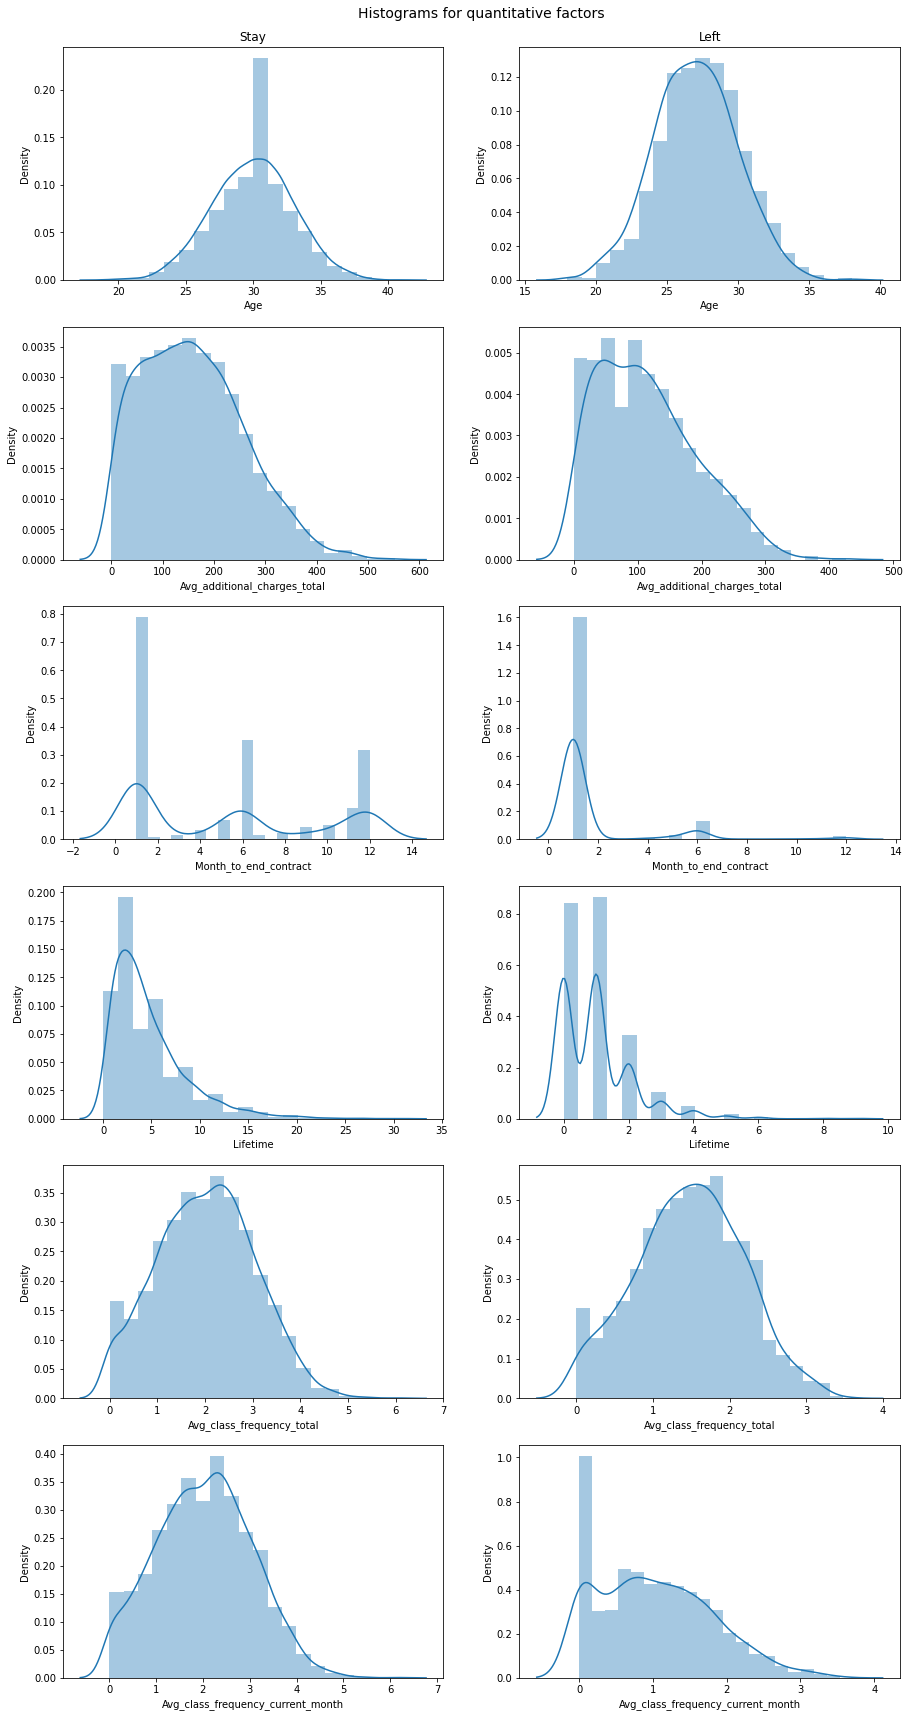

In [8]:
# создаем список количественных признаков
quantitative_factors = ['Age', 'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month']

# задаем структуру и общее название графиков
fig, axs = plt.subplots(6, 2, figsize=(15, 30))
plt.title('Histograms for quantitative factors', x=-0.1, y=7.1, fontsize=14)

# для каждого параметра строим гистограмму в разбивке по ушедшим и оставшимся клиентам
m = 0
for churn in range(2):
    n = 0
    axs[0, 0].title.set_text('Stay')
    axs[0, 1].title.set_text('Left')
    for factor in quantitative_factors:
        sns.distplot(data[data['Churn'] == churn][factor], bins=20, ax=axs[n, m])
        n += 1
    m = 1
plt.show()

Помимо уже обозначенных отличий, можно отметить "пик" людей в возрасте от 30 до 31 года среди оставшихся клиентов, и тот факт, что распределение частоты посещений ушедших клиентов за последний месяц действительно "тяготеет" к нулю.

Для наглядности также визуализируем качественные признаки в аналогичной разбивке.

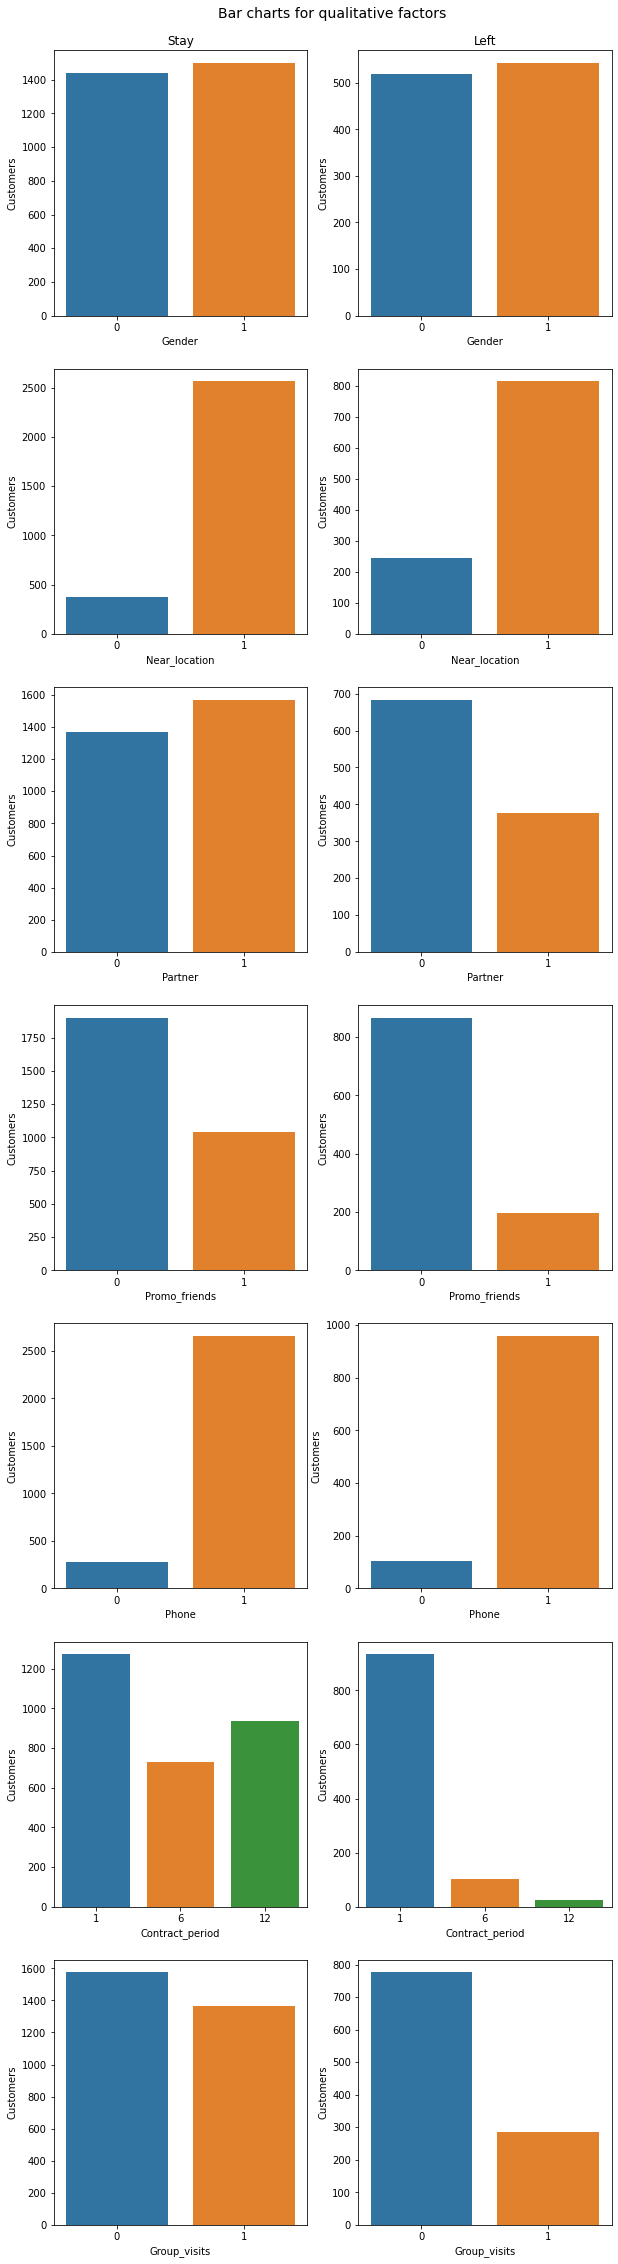

In [9]:
# создаем список качественных признаков
qualitative_factors = ['Gender', 'Near_location', 'Partner', 'Promo_friends', 'Phone', 'Contract_period', 'Group_visits']

# задаем структуру и общее название графиков
fig, axs = plt.subplots(7, 2, figsize=(10, 40))
plt.title('Bar charts for qualitative factors', x=-0.1, y=8.3, fontsize=14)

# для каждого параметра строим столбчатую диаграмму в разбивке по ушедшим и оставшимся клиентам
m = 0
for churn in range(2):
    n = 0
    axs[0, 0].title.set_text('Stay')
    axs[0, 1].title.set_text('Left')
    for factor in qualitative_factors:
        graph = sns.barplot(x=factor, y='Churn', data=data[data['Churn'] == churn], estimator=len, ax=axs[n, m])
        graph.set_ylabel('Customers')
        n += 1
    m = 1
plt.show()

Особенно явно становится выражено то, что большинство ушедших клиентов брало абонемент только на месяц.

Теперь посмотрим на корреляцию между признаками.

In [10]:
# строим матрицу корреляции
cm = data.corr() 

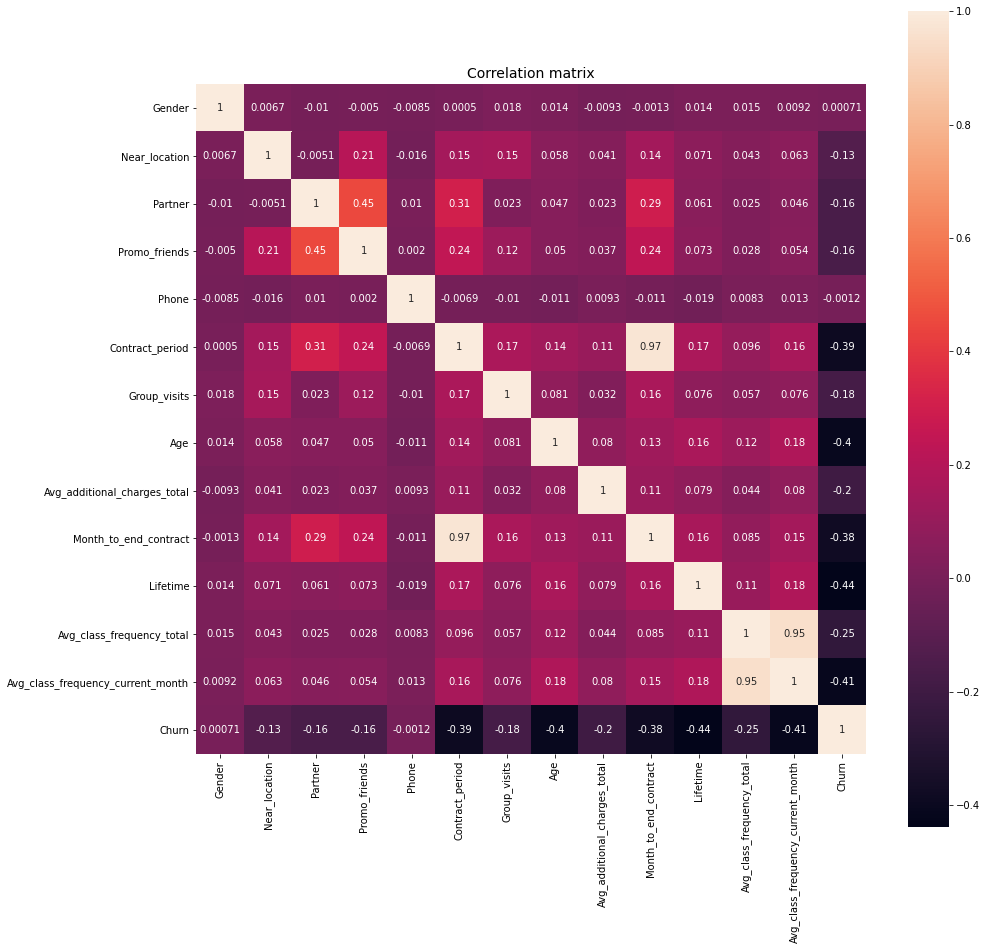

In [11]:
# визуализируем матрицу в виде тепловой карты 
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(cm, annot=True, square=True)
plt.title('Correlation matrix', fontsize=14)
plt.show()

Сильная корреляция наблюдается между длительностью абонемента и сроком до его окончания (что логично, так как один параметр по сути ограничен другим). Также частота посещений за последний месяц коррелирует с общей частотой посещений - возможно, уход клиентов удастся предсказывать заранее.

Что касается непосредственно параметра оттока, то он не обладает сильной корреляцией ни с одним из признаков, однако характеризуется умеренной отрицательной корреляцией с рядом обозначенных ранее факторов, таких как:
- возраст;
- длительность абонемента и срок до его окончания;
- общий период посещений;
- частота посещений за последний месяц.

# Часть 2 - Построение модели прогнозирования оттока клиентов

Сперва отделим столбец с целевым параметром от столбцов с остальными признаками.

In [12]:
# выделяем столбец с оттоком клиентов
X = data.drop(['Churn'], axis=1)
y = data['Churn']

Затем разобьем полученные данные на обучающую и валидационную выборки в отношении 80/20.

In [13]:
# разделяем данные на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Обучим модель на базе логистической регрессии, используя train-выборку, и применим ее к test-выборке с признаками для прогноза оттока клиентов.

In [14]:
# создаем модель на базе логистической регрессии
model = LogisticRegression(random_state=0) 

# обучаем модель и строим прогноз
model.fit(X_train, y_train)
y_pred_lr = model.predict(X_test) 

Аналогично создадим модель на базе алгоритма случайного леса.

In [15]:
# создаем модель на базе случайного леса
model = RandomForestClassifier(random_state=0) 

# обучаем модель и строим прогноз
model.fit(X_train, y_train)
y_pred_rf = model.predict(X_test)

Теперь посчитаем и сравним набор метрик (accuracy, precision и recall) для каждой из моделей.

In [16]:
# выводим метрики для модели на базе логистической регрессии
print('Metrics for logistic regression')
print('accuracy: ', accuracy_score(y_test, y_pred_lr))
print('precision: ', precision_score(y_test, y_pred_lr))
print('recall: ', recall_score(y_test, y_pred_lr))

Metrics for logistic regression
accuracy:  0.9075
precision:  0.8195876288659794
recall:  0.803030303030303


In [17]:
# выводим метрики для модели на базе случайного леса
print('Metrics for random forest')
print('accuracy: ', accuracy_score(y_test, y_pred_rf))
print('precision: ', precision_score(y_test, y_pred_rf))
print('recall: ', recall_score(y_test, y_pred_rf))

Metrics for random forest
accuracy:  0.91625
precision:  0.8393782383419689
recall:  0.8181818181818182


Мы видим, что в обоих случаях метрики показывают неплохие результаты, однако в целом случайный лес показал себя лучше (значения всех метрик для этой модели выше примерно на 1%), поэтому для прогнозов рекомендуется применять именно его.

# Часть 3 - Кластеризация клиентов

Перед началом кластеризации следует стандартизировать данные.

In [18]:
# стандартизируем данные
scaler = StandardScaler()
X_st = scaler.fit_transform(X)

Далее проведем иерархическую агломеративную кластеризацию и построим на ее основе дендрограмму.

In [19]:
# получаем таблицу "связок" между объектами 
linked = linkage(X_st, method='ward') 

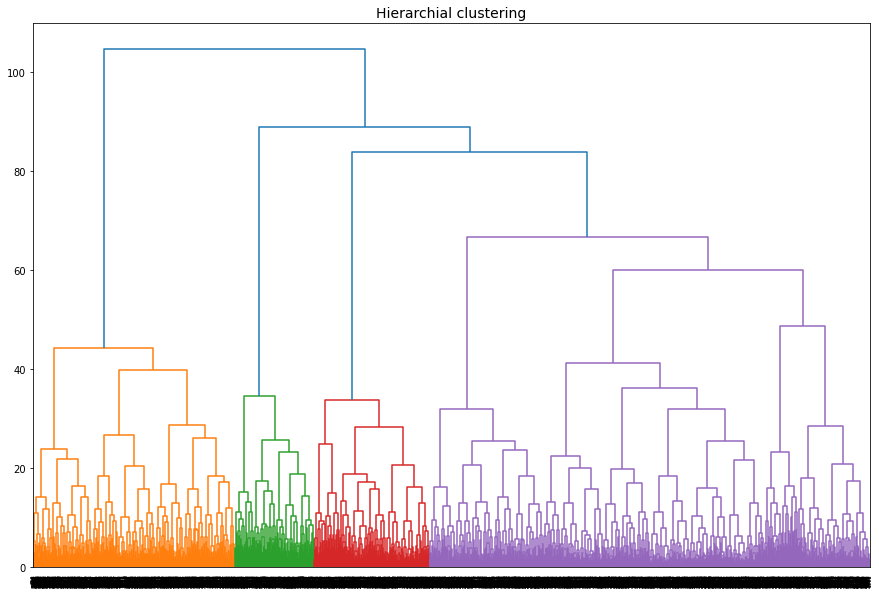

In [20]:
# строим дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering', fontsize=14)
plt.show() 

Мы видим, что внизу дендрограммы выделяются 4 кластера, однако один из них является достаточно большим и, предположительно, может быть разбит еще на 2.

В связи с этим используем модель кластеризации на основании алгоритма K-Means и зададим ей число кластеров равное 5. 

In [21]:
# применяем кластеризацию на основе алгоритма K-Means
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_st)

Запишем номера кластеров в исходную таблицу и посчитаем по ним средние значения признаков. 

In [22]:
# добавляем столбец с номерами кластеров
data['Cluster'] = labels

In [23]:
# считаем средние значения в группировке по кластерам
data.groupby('Cluster').agg('mean')

,Gender,Near_location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
Cluster,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


Сразу можно заметить, что некоторые признаки в разных кластерах принимают одно из двух бинарных значений - например, во втором кластере никто из посетителей не живет или не работает рядом с фитнес центром, а люди из первого кластера не оставляли свой номер телефона в базе.

Более подробно изучить различия между количественными значениями параметров в кластерах опять же позволят гистограммы.

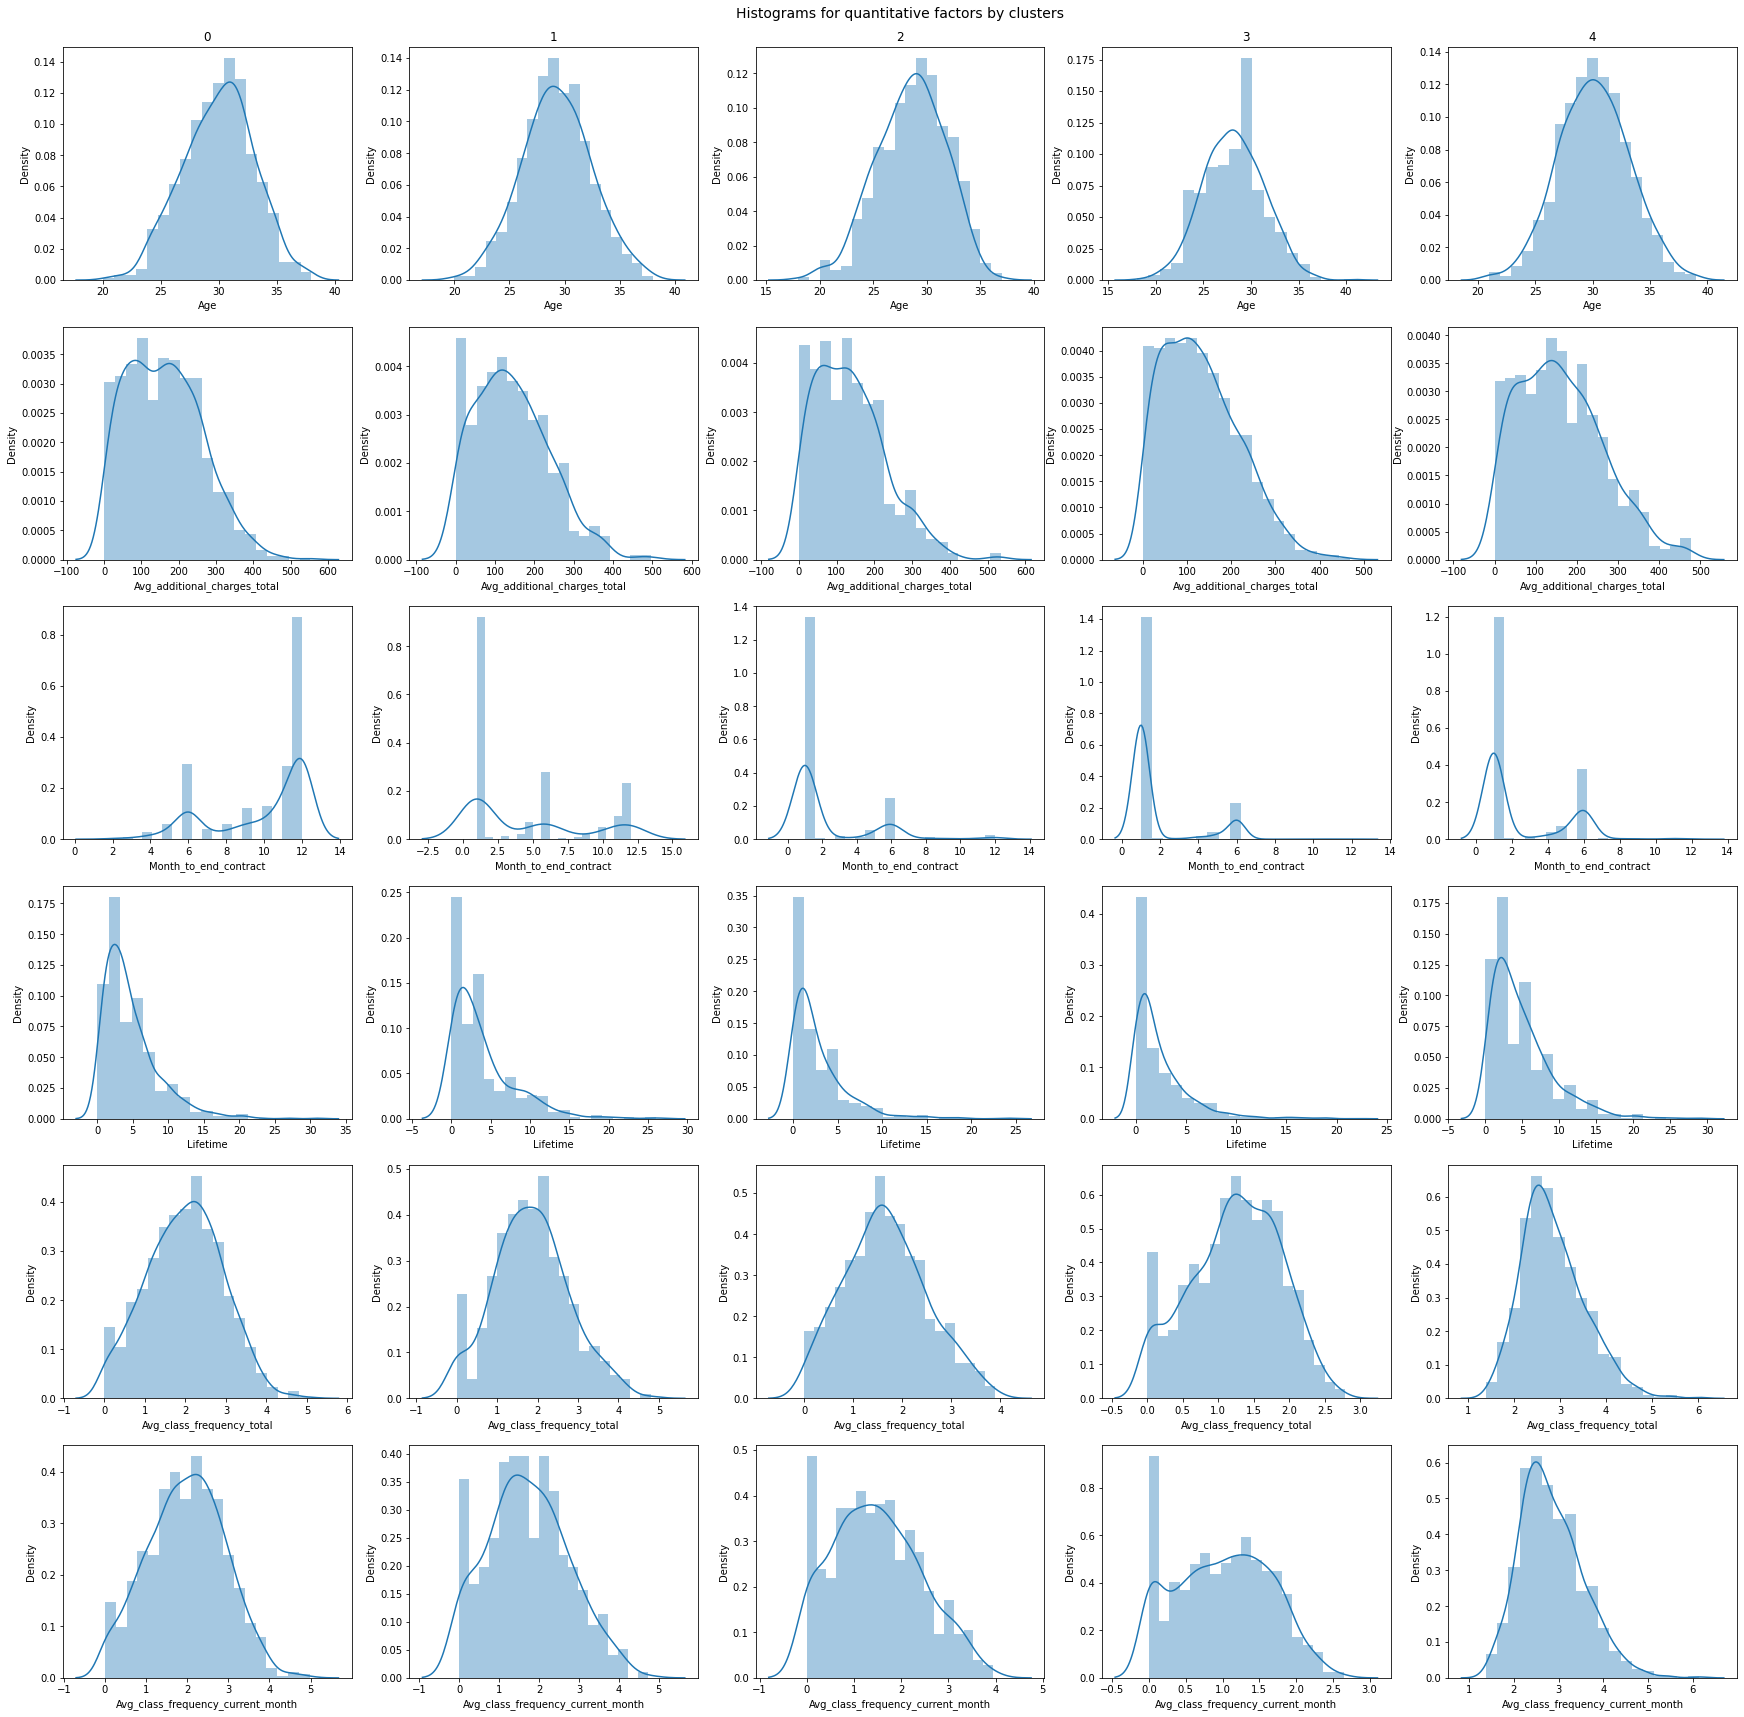

In [24]:
# задаем структуру и общее название графиков
fig, axs = plt.subplots(6, 5, figsize=(30, 30))
plt.title('Histograms for quantitative factors by clusters', x=-1.9, y=7.1, fontsize=14)

# для каждого параметра строим гистограмму в разбивке по кластерам
m = 0
for cluster in range(5):
    n = 0
    axs[0, cluster].title.set_text(cluster)
    for factor in quantitative_factors:
        sns.distplot(data[data['Cluster'] == cluster][factor], bins=19, ax=axs[n, m])
        n += 1
    m += 1
plt.show()

Мы видим следующие особенности в части распределения параметров по кластерам:
- "пик" тридцатилетних пользователей наблюдается в третьем кластере; 
- в нулевом кластере собрались клиенты с наибольшим сроком до истечения абонементов;
- общая частота занятий заметно снижается в третьем и четвертом кластерах;
- а вот частота занятий в последний месяц стабильна только в нулевом кластере.

Оценим также различия категориальных параметров.

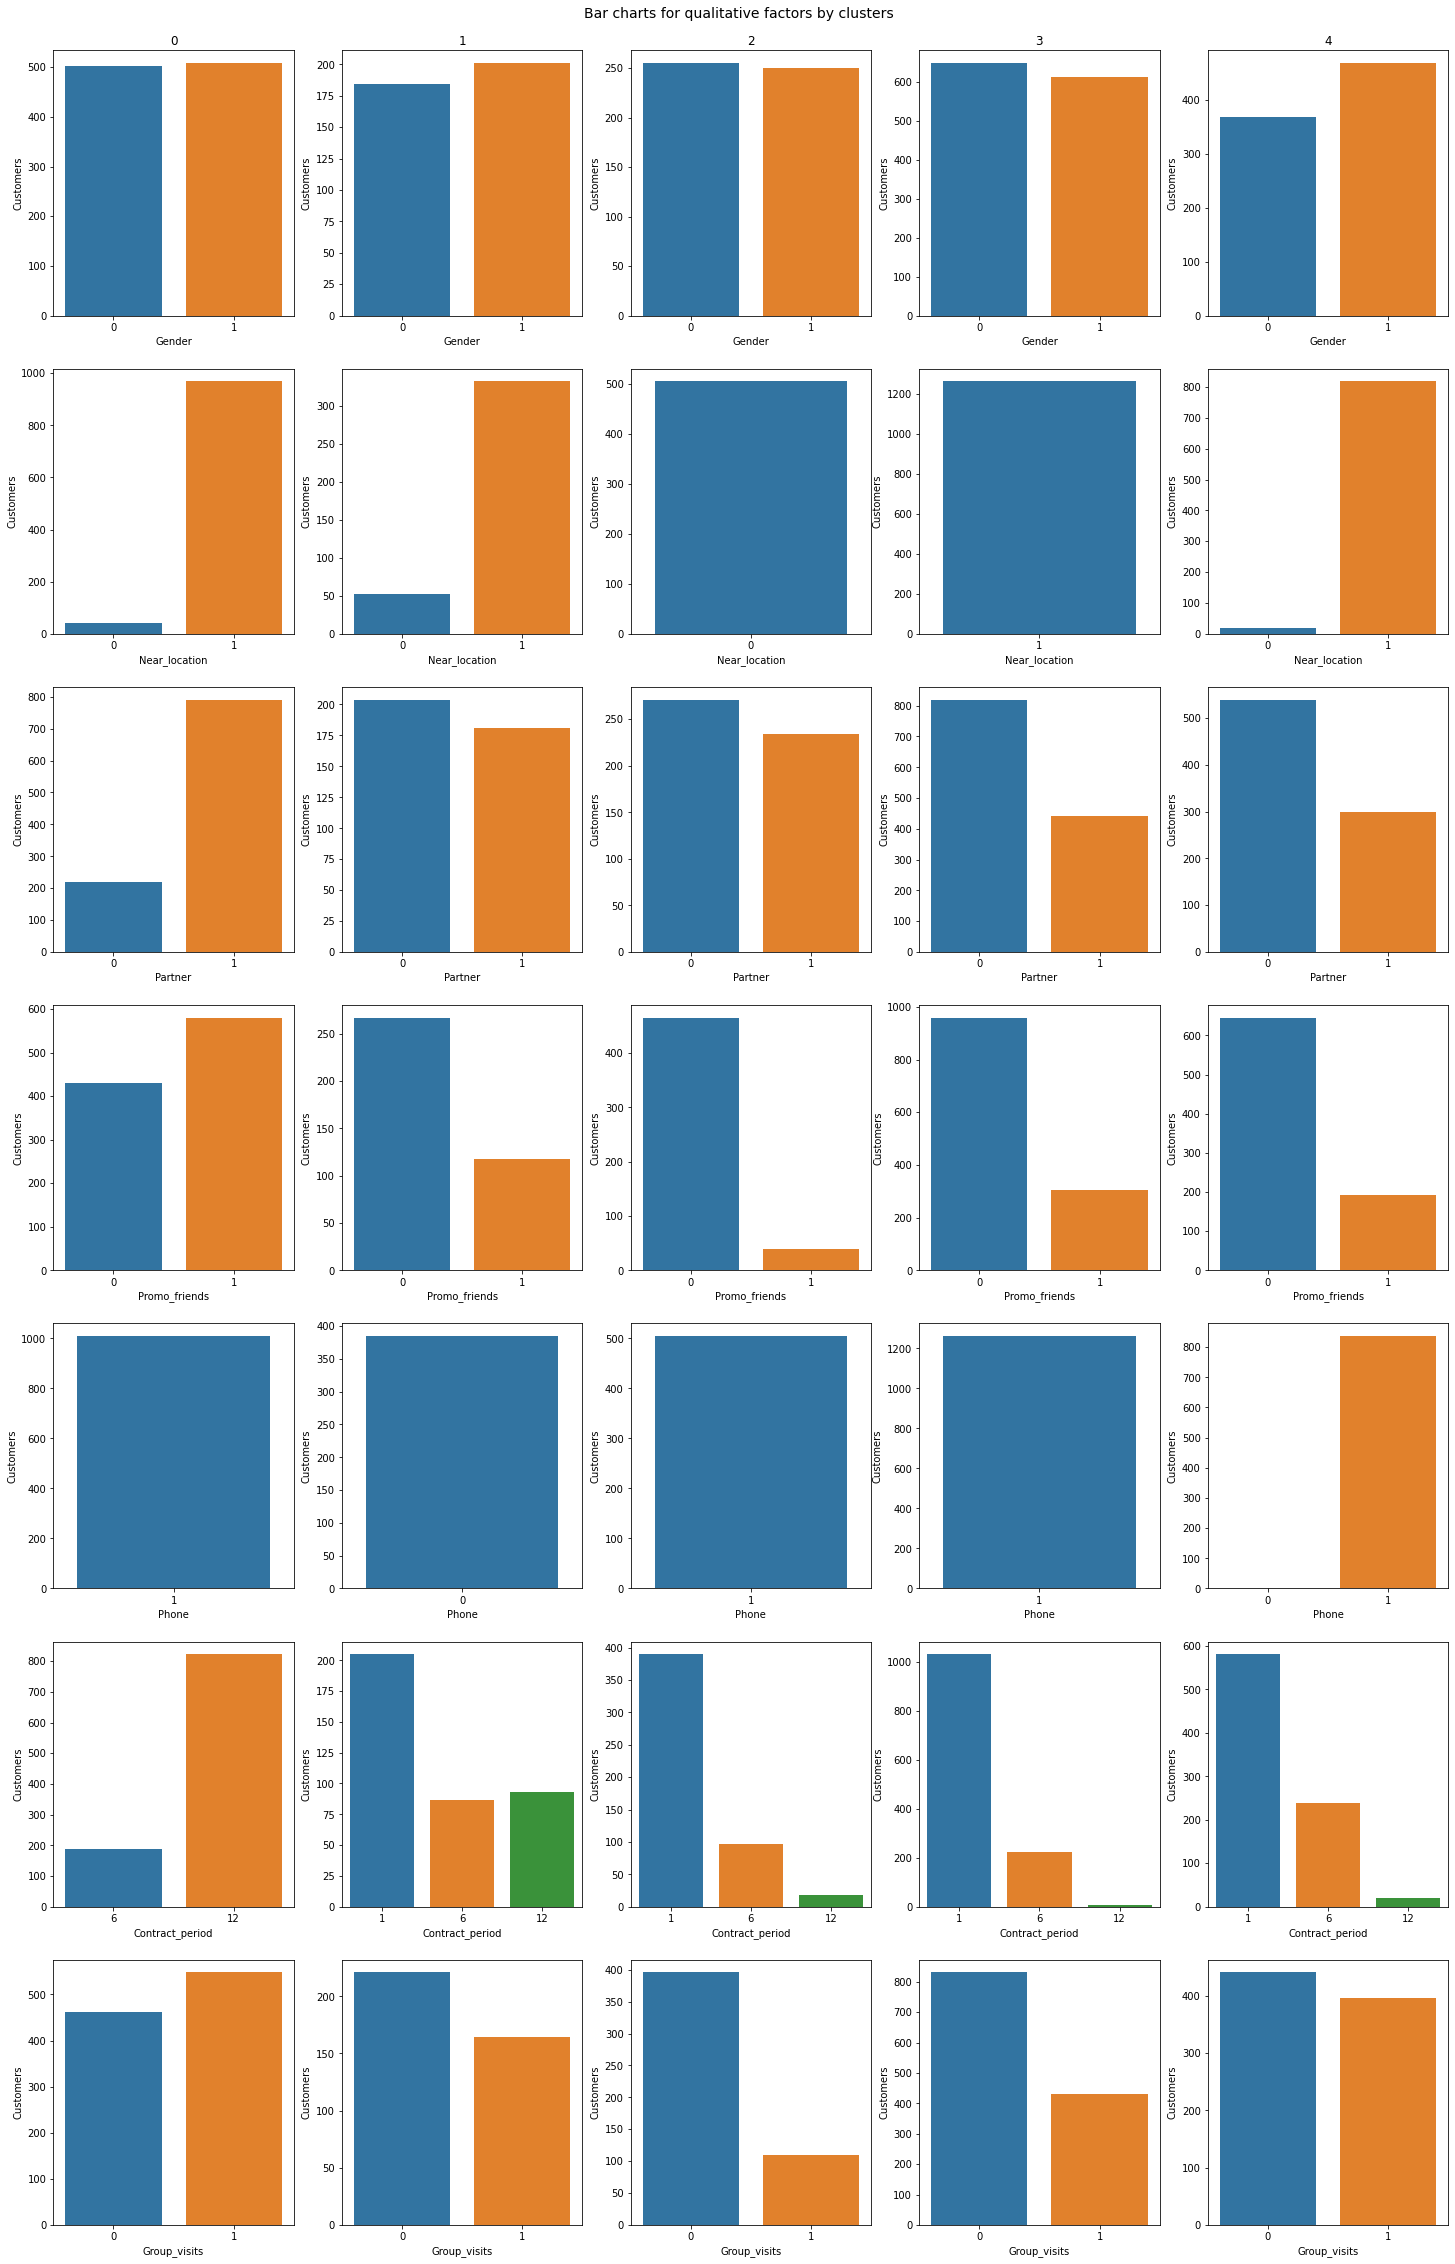

In [25]:
# задаем структуру и общее название графиков
fig, axs = plt.subplots(7, 5, figsize=(25, 40))
plt.title('Bar charts for qualitative factors by clusters', x=-1.95, y=8.3, fontsize=14)

# для каждого параметра строим столбчатую диаграмму в разбивке по кластерам
m = 0
for cluster in range(5):
    n = 0
    axs[0, cluster].title.set_text(cluster)
    for factor in qualitative_factors:
        graph = sns.barplot(x=factor, y='Churn', data=data[data['Cluster'] == cluster], estimator=len, ax=axs[n, m])
        graph.set_ylabel('Customers')
        n += 1
    m += 1
plt.show()

Мы видим, что в нулевом кластере, в отличие от остальных, преобладают партнерские скидки, записи по акции и групповые занятия. Кроме того, в этом кластере вообще нет краткосрочных абонементов, в то время как в других кластерах их количество является преобладающим.

Таким образом, каждому кластеру можно присвоить следующие характеристики:
- кластер 0 - "активные" - это люди, которые максимально используют все доступные возможности фитнес-центра и менее всего склонны к оттоку;
- кластер 1 - "умеренные" - люди, в меньшей степени пользующиеся различными акциями и сервисами, но все еще достаточно часто оформляющие абонемент со сроком полгода или год (также по этим клиентам в базе отсутствуют номера телефонов);
- кластер 2 - "неместные" - люди, живущие или работающие не в районе расположения фитнес-центра и поэтому обладающие слабыми социальными связями с другими клиентами (минимум по числу акций "приведи друга" и посещению групповых занятий);
- кластер 3 - "краткосрочные" - люди, имеющие наибольшее число абонементов сроком в месяц и, как следствие, более склонные к оттоку; 
- кластер 4 - "групповые" - люди, живущие или работающие в районе расположения фитнес-центра и среди прочего склонные к групповым занятиям (возможно, это люди из одних и тех же компаний/организаций).

Наконец, посчитаем долю оттока по кластерам.

In [26]:
data.groupby('Cluster').agg('mean')['Churn']

Cluster
0    0.027723
1    0.267532
2    0.443564
3    0.514263
4    0.068019
Name: Churn, dtype: float64

С учетом всех наблюдений, не удивительно, что именно нулевой кластер является самым "надежным", обладая наименьшей долей оттока. Низкая доля оттока также наблюдается в четвертом кластере, который отличается от прочих относительно высокой долей групповых визитов и большим числом клиентов, живущих или работающих в районе фитнес-центра.

Кластеры с людьми, находящимися на удалении от фитнес-центра (кластер 2) или ориентированными на краткосрочные занятия (кластер 3), по понятным причинам характеризуются наибольшей долей оттока.

# Выводы

1) В ходе проведенного исследования были выявлены основные признаки, влияющие на отток клиентов, к ним относятся:
- Факты записи по акциям, партнерские скидки и посещения групповых занятий;
- Продолжительность абонемента и срок до его окончания;
- Частота посещений занятий в целом и за последний месяц.

Чем ниже доля/значения данных факторов, тем более вероятно, что клиент уйдет в ближайшее время.

2) Последний фактор (частота занятий) представляется наиболее значимым с точки зрения прогнозирования оттока клиентов. При этом прогнозная модель, построенная на базе алгоритмов случайного леса, показала наилучшие результаты со значениями метрик accuracy, precision и recall на уровне 0.8-0.9.

3) Кластеризация клиентов позволила выделить несколько основных групп:
- "Активные" клиенты, характеризующиеся высокими значениями всех параметров из первого пункта (доля оттока < 3%);
- "Групповые" клиенты, проживающие/работающие в районе фитнес-центра и посещающие групповые занятия - это могут быть, например, люди из одной компании (доля оттока < 7%);
- Прочие клиенты, показывающие более высокую долю оттока и между собой отличающиеся по вторичным признакам, таким как наличие в базе номера телефона (доля оттока между 26% и 51%).

4) Исходя из вышесказанного, можно сделать несколько маркетинговых рекомендаций:
- активнее стимулировать людей использовать акции типа "приведи друга" и посещать групповые занятия - подобная "социальность" повышает уровень удержания клиентов;
- пересмотреть баланс привлечения клиентов в части разной продолжительности абонементов - более выгодные условия для посетителей со средне- и долгосрочными абонеметнами могут также принести выгоду фитнес-центру;
- делать напоминания (звонки/рассылки с предложениями) клиентам, значительно снизившим частоту занятий;
- дополнительно рассмотреть сегмент клиентов в возрасте около 30 лет - в это время люди активно начинают заниматься своим здоровьем, возможно, следует учесть эту мотивацию при продвижении услуг.